In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Data and Problem 

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


### Data
This task is asking for my model to be able to identify tweets discussing a real disaster. These tweets can use similar words but in different contexts. Meaning one tweet with the word 'ablaze' could be discussing a forest fire, whereas another could be describing a sunset. One would be labeled a disaster while the other would not be labeled a disaster. My models job is to define what is actually a disaster. 
### Data Attributes
The data has multiple columns including id, text, keyword, location, and target.  ID is just a unique label for the sample. The text is the most import information and contains the contents of the tweet. Keyword can be null, but if it is not, it will contain a relevant word for disasters. Location is where the tweet was sent from and can also be Null. The target for the training data is a label indicating if the tweet pertains to a disaster or not. The size of the data is 7613 samples for training and 3263 samples for testing. It appears that the keyword column is nearly always populated, but the location column is closer to 2/3 times populated. I will explore this more in the EDA section. 

# EDA
Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

I want to visualize the number of tweets with ID, Keyword and Location to get a better sense of the number of null values I am working with in training and test data sets.

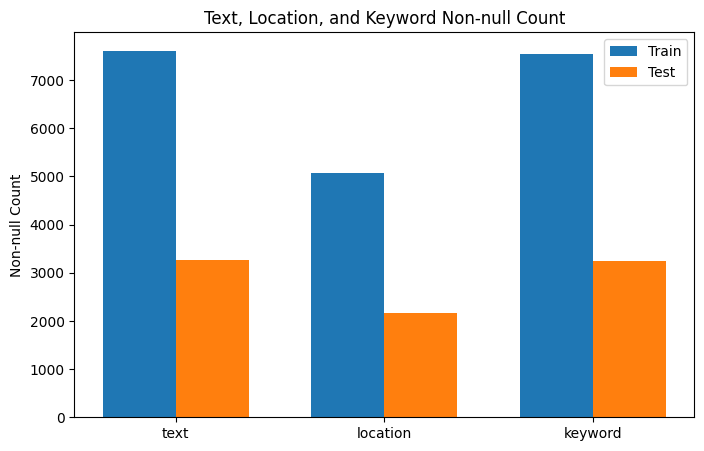

In [9]:
# Histogram of training and testing data with non null values for each column shown
import numpy as np
import matplotlib.pyplot as plt

#getting counts of non null values 
train_counts = [
    df_train['text'].notnull().sum(),
    df_train['location'].notnull().sum(),
    df_train['keyword'].notnull().sum()
]

test_counts = [
    df_test['text'].notnull().sum(),
    df_test['location'].notnull().sum(),
    df_test['keyword'].notnull().sum()
]

#setting up labels and x axis
labels = ['text', 'location', 'keyword']
x = np.arange(len(labels))  
width = 0.35 

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, train_counts, width, label='Train')
rects2 = ax.bar(x + width/2, test_counts, width, label='Test')

ax.set_ylabel('Non-null Count')
ax.set_title('Text, Location, and Keyword Non-null Count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


It appears that keywords are available for nearly every sample, whereas location values are available for about 2/3 the samples.

Next, I want to create a histogram of the most used keywords and locations.

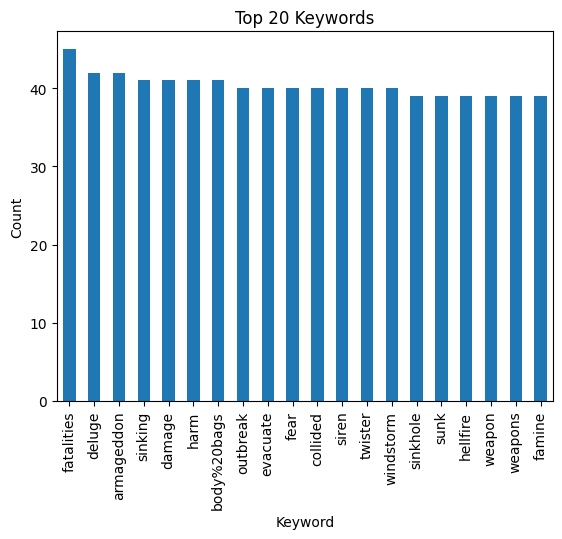

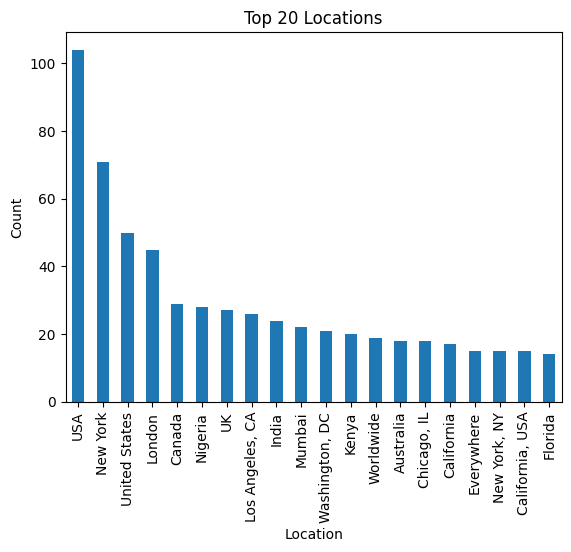

In [27]:
#most used keywords
df_train['keyword'].dropna().value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Keywords")
plt.xlabel("Keyword")
plt.ylabel("Count")
plt.show()

#most used locations
df_train['location'].dropna().value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Locations")
plt.xlabel("Location")
plt.ylabel("Count")
plt.show()

Since there are so many keywords that appear around the same amount, I will do a word cloud for keywords as well as text information. 
The location data shows that it is most likely clipped from the text so different versions of the same location are displayed. I am curious if location is included, are there higher chances of disaster?

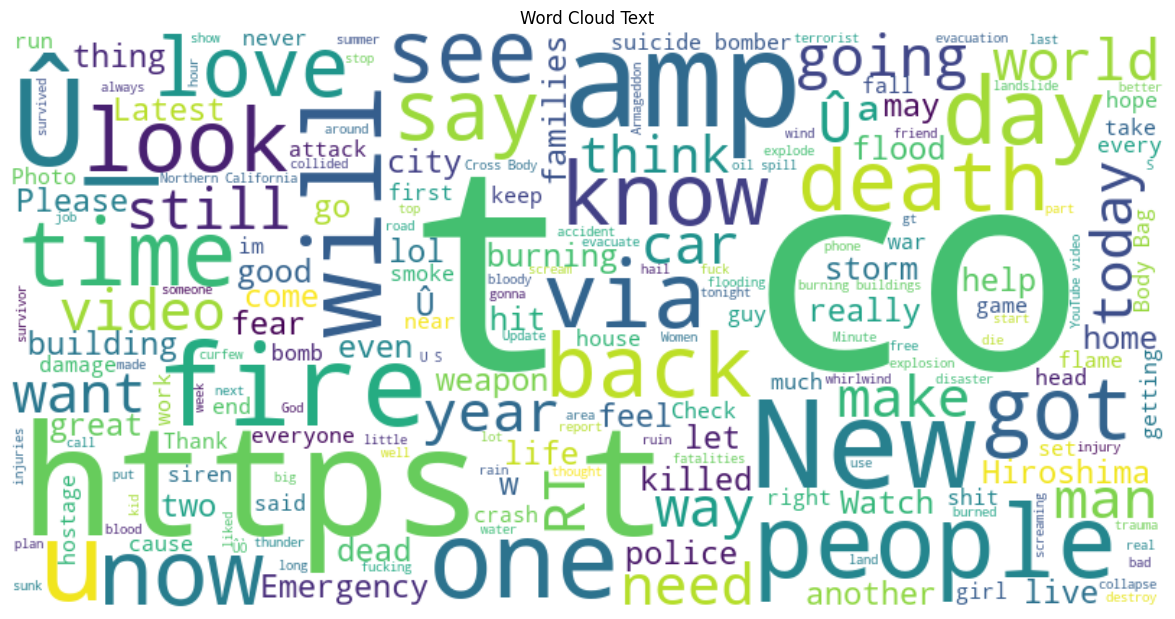

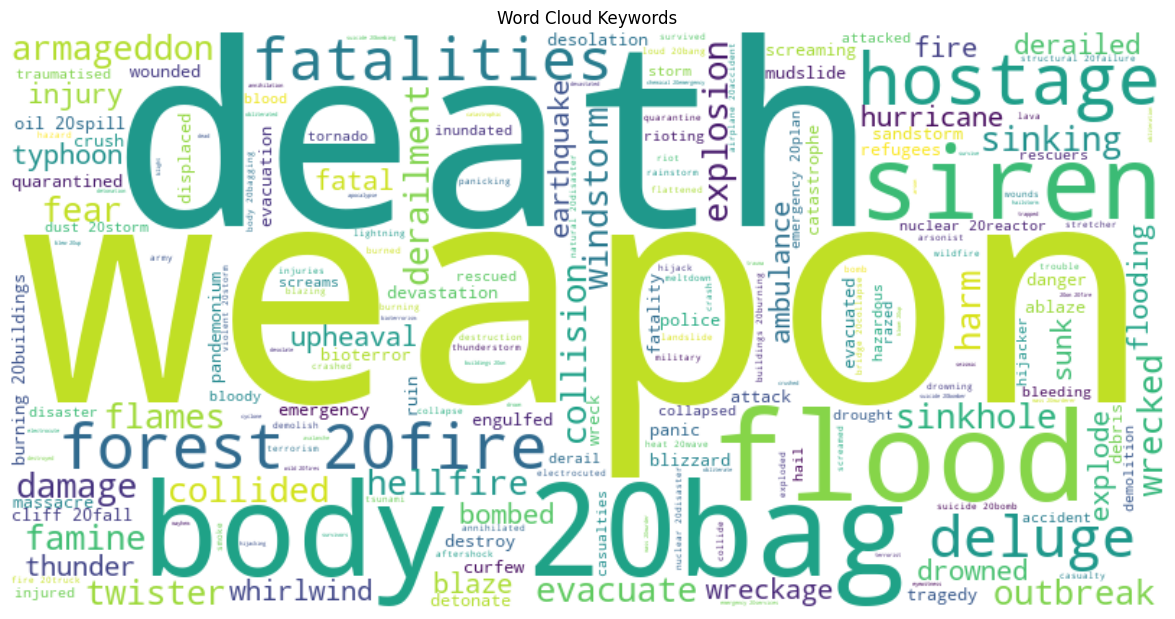

In [ ]:
# Word Cloud
from wordcloud import WordCloud
import random

text = " ".join(tweet for tweet in df_train['text'] if tweet is not None)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Text')
plt.show()

#had some issues with getting single keywords to show up. Was showing double words so randomized list before concatenating into a string
keyword_list = df_train['keyword'].dropna().tolist()
random.shuffle(keyword_list)
keywords_text = " ".join(keyword_list)

#now with randomized keywords_text I can create wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(keywords_text)
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Keywords')
plt.show()

### Text Word Cloud
This is interesting because there are many keywords appearing in the text word cloud along more normal words. Since these are tweets and not full articles, the emphasis on important words has increased and the use of articles, pronouns, and other well used words has decreased. 
### Keyword Word Cloud
Interestingly, there are a lot of different keywords in this word cloud. Most can be used in different context which makes this problem more complicated. For instance, weapon can indicate a disaster or could be used to describe a good player on a sports team. 

Next I want to explore the distribution of disaster vs non disaster tweets.

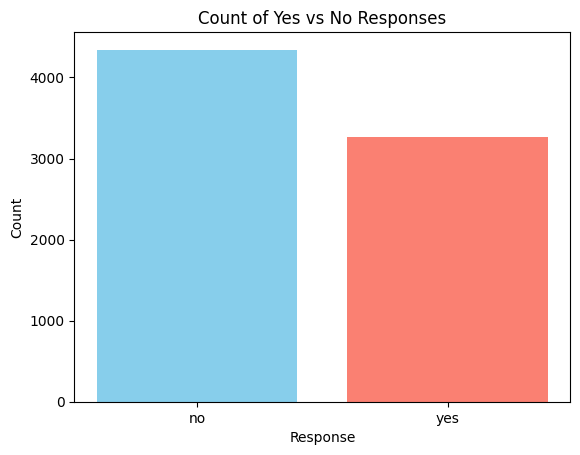

In [30]:
counts = df_train['target'].value_counts()

plt.bar(counts.index, counts.values, color=['skyblue', 'salmon'])
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Count of Yes vs No Responses')

plt.xticks(ticks=[0, 1], labels=['no', 'yes'])
plt.show()

This shows that the disaster vs non distaster tweets are relatively even with non disaster tweets being slightly more prevalent. 

The last EDA visualization I want to see is length of tweet text overlayed with the probability of disaster vs non disaster tweet. 

/var/folders/fx/dljhb1xs01zd1r8n975gbtcc0000gn/T/ipykernel_74084/251339318.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_train.groupby(['length_bin', 'target']).size().unstack(fill_value=0)


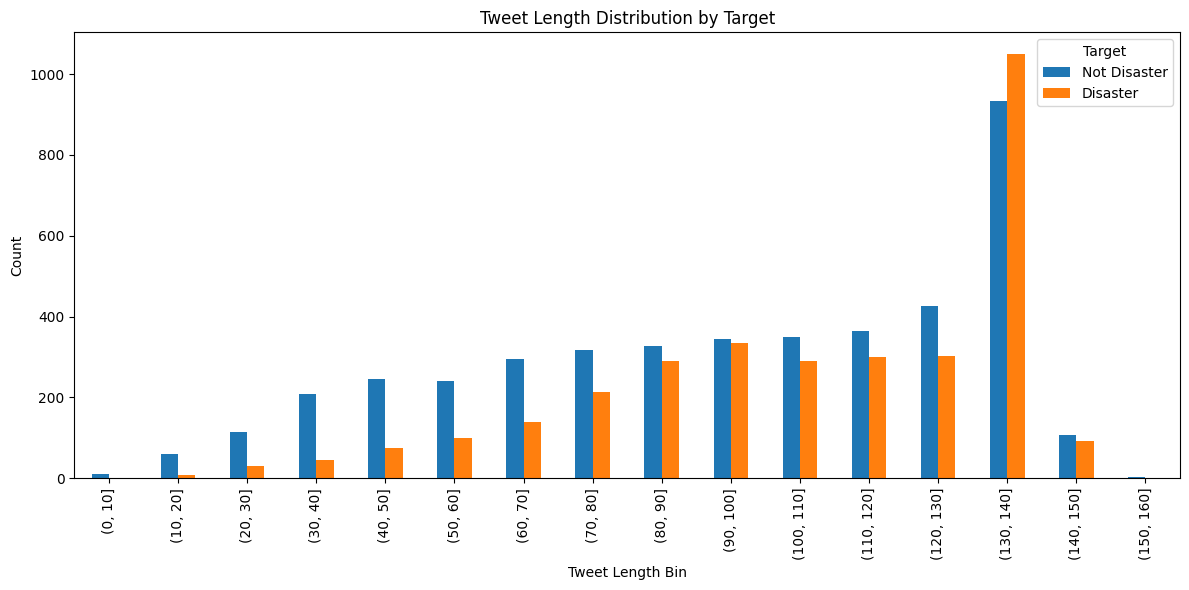

In [31]:
# first I want to create a new column of text lengths
df_train['tweet_length'] = df_train['text'].apply(len)

#create bins for the plot
max_length = df_train['tweet_length'].max()
bins = range(0, max_length + 10, 10)
df_train['length_bin'] = pd.cut(df_train['tweet_length'], bins=bins)

grouped = df_train.groupby(['length_bin', 'target']).size().unstack(fill_value=0)

#plot tweet length by count for disaster vs non disaster tweets
ax = grouped.plot(kind='bar', figsize=(12, 6))
ax.set_xlabel('Tweet Length Bin')
ax.set_ylabel('Count')
ax.set_title('Tweet Length Distribution by Target')
ax.legend(title='Target', labels=['Not Disaster', 'Disaster'])

plt.tight_layout()
plt.show()

### Reflection on length vs counts of disaster/non-disaster
This goes against what I assumed. I thought shorter tweets would be more urgent and correlate with a higher disaster to non disaster ratio. It turns out it is the opposite and longer tweets have a higher correlation to being a disaster vs non disaster. 

## Cleaning
Next, I will clean the data so it can be best used buy my model in the next section.  First I want to see what some of the text data looks like

In [38]:
pd.set_option('display.max_colwidth', None)
print(df_train['text'].head(20))

0                                                                     Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1                                                                                                    Forest fire near La Ronge Sask. Canada
2     All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3                                                                         13,000 people receive #wildfires evacuation orders in California 
4                                                  Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
5                            #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
6                                           #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
7                   

From the texts above, there is lots of different hashtags, capitalization differences, different punctuations used and thats just the first 20 or so texts. In the word cloud, https appeared many times, along with RT for retweet, capitalizations and U with ^.  I implemented some regex expressions below to clean these texts so when they are broken down into matrix form there will be a smaller word distribution.

In [39]:
import re

def clean_text(text):
    #Remove RT
    text = re.sub(r'\bRT\b', '', text)
    #Remove http with and without s
    text = re.sub(r'https?://\S+', '', text)
    #Remove U with a caret
    text = re.sub(r'[Ûû]', '', text)
    #Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    #Make text lowercase
    text = text.lower()
    return text

df_train['text_clean'] = df_train['text'].apply(clean_text)


I chose to keep hashtags since they seem to alert importance of a word and that could be useful for recognizing a disaster in a tweet. Next I will move onto modeling architecture and embedding the text. 

# Model Architecture
Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

Research for different word embeddings to use
### Count Vectorizer
From my understanding, this just assigns a number to each unique word in the text. This way it can be read as a number by the model and show up as a 1 if it is in the vocabulary and a 0 if it is not.  This would be for the sparse matrix representation of transforming text. It then has a few parameters like min df and max df that limit the vocabulary based on how many or how few times a word appears. There is also max_features that limits the size of the vocabulary to the most frequent. This gets rid of the information about order of the tweets which the RNN model would be good at getting information from. 
### TF IDF
This is similar to a count vectorizer but scales the terms weights based on two factors. First up scaling by term frequency within the document and then down scaling by the 'Inverse Document Frequency' which is the amount the word appears across texts or documents. This also gets rid of information about order of the text which I want to be available for my RNN to learn from.
### Word2Vec
This technique uses an embedding that includes relation to other words in the window specified. The window is an adjustable hyperparameter that takes in the number of words around the word that it could relate to. Additionally, this article points out that there are pre trained word2vec that have a much larger training size and are more accurate for smaller samples like the one here. 
### Fast Text
This is similar to word2vec but it breaks down words into its pieces or n-grams and then associates those pieces of words together. This could be useful in this instance where people are using different words in there tweets or adding letters for emphasis like Fireeee instead of fire. Here fast text could still get meaning from the parts of fireeee but word2vec would not get meaning from it and treat the words very differently. 
### GloVe
Glove is similar to word2vec in that it takes into account other words around the word being embedded. 
It uses a co-occurrence matrix to make these relationships between words. It also has pretrained models provided by stanford for smaller data sets where there isn't enough data to train on. 

### Choice
Although all of these models ignore context of a word to some degree, I like the aspects of the pretrained models of GloVe and word2Vec. I will try both and see which architecture is more fruitful with an RNN in sequence with them. 

In [40]:
#first I will tokenize the text data so that it can be fed into the pretrained word2vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Vocab limit
vocab_size = 25000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>") #if not in vocab assign OOV token
tokenizer.fit_on_texts(df_train['text'].values)

X_text_seq = tokenizer.texts_to_sequences(df_train['text'].values)

#want padded sequences of the same length
max_length = 100
X_text_padded = pad_sequences(X_text_seq, maxlen=max_length, padding='post', truncating='post')

In [ ]:
from gensim.models import KeyedVectors

#load word2vec 
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Results and Analysis
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

# Conclusion
Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

In [ ]:
#Add test submission code here with trained model above
#don't forget to tokenize the test data the same way as the train data

# References
Blog post talking about different ways to embed words - covers a lot of good information that I discuss at the top of the Model Architecture section. 
https://neptune.ai/blog/document-classification-small-datasets